# Klein model
> Does the Klein model allow us to circumvent the hyperboloid modifications to decision trees?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import anndata

from hyperdt.tree import HyperbolicDecisionTreeClassifier
from hyperdt.tree import DecisionTreeClassifier as EuclideanDecisionTreeClassifier
from hyperdt.conversions import convert
from sklearn.tree import DecisionTreeClassifier

In [3]:
# Basic sanity check: anndata

import sys

sys.path.append("/home/phil/americangut")
from make_xy import make_anndata_X_y

In [4]:
adata = anndata.read_h5ad("/home/phil/americangut/data/big_table_with_embeddings.h5ad")

X_hyp, y_hyp = make_anndata_X_y(column="ibd", balance=True, embedding="hyp_mix_2", adata=adata, seed=42)
print(X_hyp.shape)

X_poi, y_poi = make_anndata_X_y(column="ibd", balance=True, embedding="poi_mix_2", adata=adata, seed=42)

(2690, 3)


In [5]:
# Convert to Klein model


# def hyperboloid_to_klein(X, timelike_dim=0):
#     """Simple make the timelike coordinate equal to 1"""

#     # Input validation
#     X = np.asarray(X)
#     if X.ndim == 1:
#         X = X.reshape(1, -1)

#     # Put timelike dimension first
#     X = np.roll(X, -timelike_dim, axis=1)

#     return X[:, 1:] / (1 + X[:, 0, None])


# X_klein = hyperboloid_to_klein(X_hyp, timelike_dim=-1)
X_klein = convert(X_hyp, initial="hyperboloid", final="klein", timelike_dim=-1)
# X_klein = convert(X_poi, initial="poincare", final="klein")

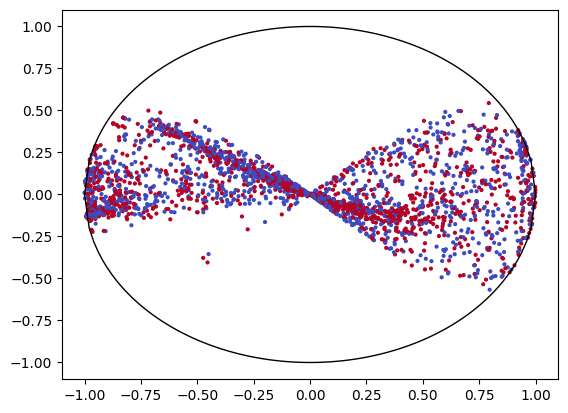

In [6]:
# Plot Klein embeddings
plt.scatter(X_klein[:, 0], X_klein[:, 1], c=y_hyp, cmap="coolwarm", s=4)

# Plot unit circle
x = np.linspace(-1, 1, 100)
y = np.sqrt(1 - x**2)
plt.plot(x, y, c="k", linewidth=1)
plt.plot(x, -y, c="k", linewidth=1)

In [7]:
# Check that hyperboloid is actually a hyperboloid

assert np.allclose(np.sum(X_hyp[:, :-1] ** 2, axis=1) - X_hyp[:, -1] ** 2, -1)
assert np.all(X_hyp[:, -1] >= 1)
assert np.all(X_hyp[:, -1] > np.linalg.norm(X_hyp[:, :-1], axis=1))

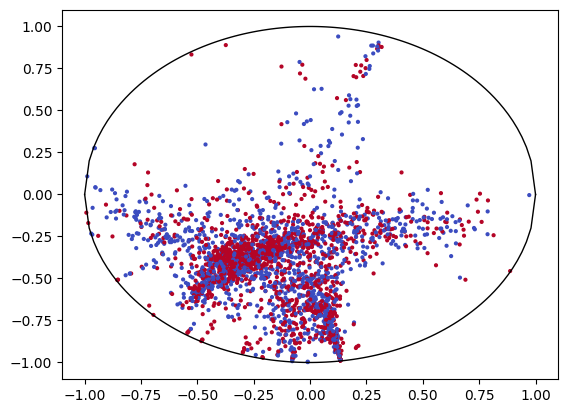

In [8]:
# For reference, plot Poincare embeddings

plt.scatter(X_poi[:, 0], X_poi[:, 1], c=y_poi, cmap="coolwarm", s=4)

# Plot unit circle
x = np.linspace(-1, 1, 100)
y = np.sqrt(1 - x**2)
plt.plot(x, y, c="k", linewidth=1)
plt.plot(x, -y, c="k", linewidth=1)

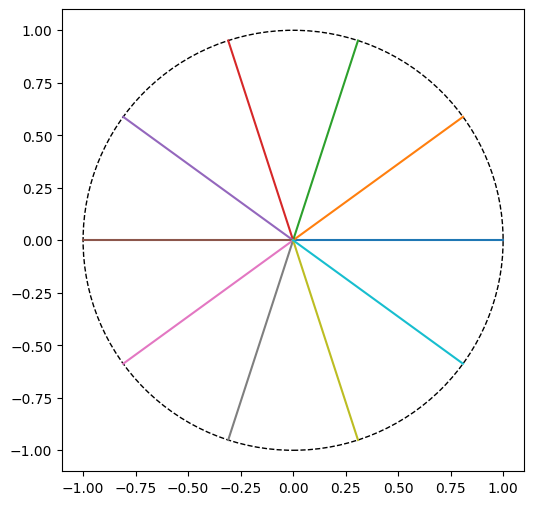

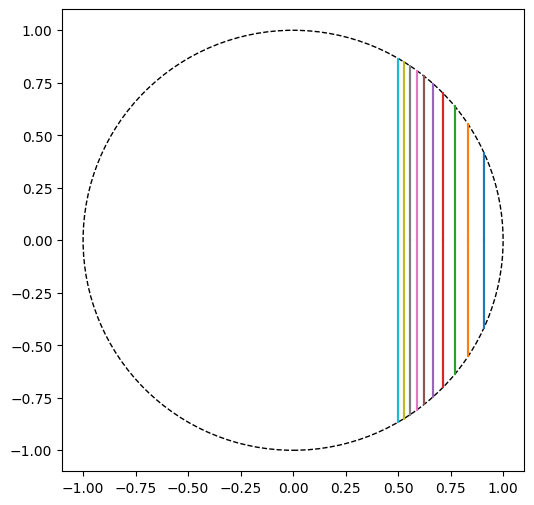

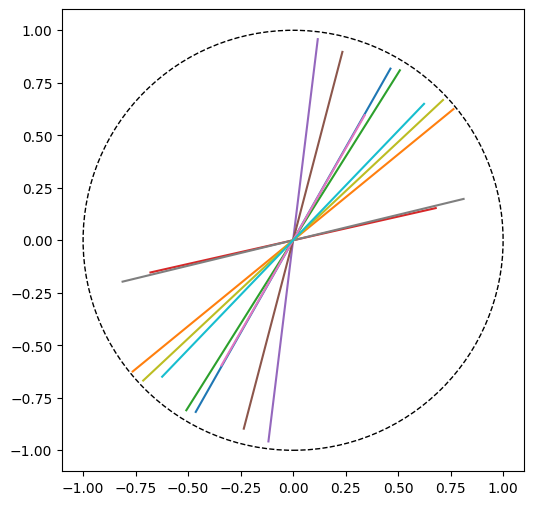

In [9]:
# Verify that geodesics in Poincare map to straight lines in Klein - ChatGPT
# Yes, this works!


def draw_poincare_disk():
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.add_artist(plt.Circle((0, 0), 1, fill=False, color="black", linestyle="dashed"))
    ax.set_aspect("equal", "box")
    return ax


def kleinify(x, y):
    X = np.stack((x, y), axis=1)
    X = convert(X, initial="poincare", final="klein")
    x = X[:, 0]
    y = X[:, 1]
    return x, y


def radial_geodesics(n=10, klein=False):
    ax = draw_poincare_disk()
    thetas = np.linspace(0, 2 * np.pi, n, endpoint=False)
    for theta in thetas:
        t = np.linspace(0, 0.999, 100)  # Stopping at 0.999 to keep inside the disk
        x = t * np.cos(theta)
        y = t * np.sin(theta)
        x, y = kleinify(x, y) if klein else (x, y)
        ax.plot(x, y)
    plt.show()


def circular_geodesics(n=10, klein=False):
    ax = draw_poincare_disk()
    centers = np.linspace(1.1, 2, n)  # Starting at 1.1 to be outside the disk
    for c in centers:
        r = np.sqrt(c**2 - 1)
        theta = np.linspace(0, 2 * np.pi, 100)
        x = r * np.cos(theta) + c
        y = r * np.sin(theta)
        x, y = kleinify(x, y) if klein else (x, y)
        ax.plot(x, y)
    plt.show()


def diametrical_geodesics(n=10, klein=False):
    ax = draw_poincare_disk()
    points = np.random.rand(n, 2) * 0.8  # Random points inside the disk
    for p in points:
        x = [p[0], -p[0]]
        y = [p[1], -p[1]]
        x, y = kleinify(x, y) if klein else (x, y)
        ax.plot(x, y)
    plt.show()


radial_geodesics(klein=True)
circular_geodesics(klein=True)
diametrical_geodesics(klein=True)

In [11]:
# Compare hdt to dt+Klein

args = {"max_depth": 20}

hdt = HyperbolicDecisionTreeClassifier(timelike_dim=-1, **args)
hdt.fit(X_hyp, y_hyp)
hdt_score = hdt.score(X_hyp, y_hyp)

kdt = DecisionTreeClassifier(**args)
kdt.fit(X_klein, y_hyp)
kleindt_score = kdt.score(X_klein, y_hyp)

print(f"HDT score: {hdt_score}")
print(f"Klein DT score: {kleindt_score}")

HDT score: 0.8687732342007435
Klein DT score: 0.8494423791821561


In [15]:
# Let's quickly check the IBD data

X_ibd, y_ibd = make_anndata_X_y(column="ibd", embedding="hyp_mix_128", balance=True, seed=42, adata=adata)
X_ibd_klein = convert(X_ibd, initial="hyperboloid", final="klein", timelike_dim=-1)

# Sanity check: everything is inside unit circle
assert np.all(np.linalg.norm(X_ibd_klein, axis=1) <= 1)

In [16]:
# kdt on IBD data
from sklearn.model_selection import train_test_split

X_ibd_klein_train, X_ibd_klein_test, y_train, y_test = train_test_split(
    X_ibd_klein, y_ibd, test_size=0.2, random_state=42
)

kdt_ibd = DecisionTreeClassifier(max_depth=4)

kdt_ibd.fit(X_ibd_klein_train, y_train)

kdt_ibd_score = kdt_ibd.score(X_ibd_klein_test, y_test)
print(f"KDT IBD score: {kdt_ibd_score}")

KDT IBD score: 0.5947955390334573


In [17]:
# Does it beat PCA?
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_ibd_pca, y_ibd = make_anndata_X_y(adata, column="ibd", balance=True, embedding=None, seed=42, to_dense=True)

X_ibd_pca_train, X_ibd_pca_test, y_ibd_train, y_ibd_test = train_test_split(
    X_ibd_pca, y_ibd, test_size=0.2, random_state=42
)

pca = PCA(n_components=128)

pca.fit(X_ibd_pca_train)

X_ibd_pca_train = pca.transform(X_ibd_pca_train)
X_ibd_pca_test = pca.transform(X_ibd_pca_test)

# Train dt
pca_dt = DecisionTreeClassifier(random_state=42, max_depth=4)
pca_dt.fit(X_ibd_pca_train, y_ibd_train)

# Test dt
pca_dt_score = pca_dt.score(X_ibd_pca_test, y_ibd_test)
print(f"PCA Decision Tree Score: {pca_dt_score}")

PCA Decision Tree Score: 0.5855018587360595


In [18]:
# What if we did a simpler, more hyperbolic classification task?

otu_embeddings_poi = adata.varm["component_embeddings_poincare_4"]
classes = adata.var["taxonomy_1"]
classes_keep = classes.isin(
    [
        "p__Firmicutes",
        "p__Proteobacteria",
        "p__Bacteroidetes",
        "p__Actinobacteria",
        "p__Acidobacteria",
        "p__Planctomycetes",
    ]
)
classes = classes.loc[classes_keep]
otu_embeddings_poi = otu_embeddings_poi.loc[classes_keep]

# Sample a random 1000 OTUs
np.random.seed(42)
sample = np.random.choice(otu_embeddings_poi.index, 2000, replace=False)
otu_embeddings_poi = otu_embeddings_poi.loc[sample]
classes = classes.loc[sample]

In [19]:
from sklearn.model_selection import train_test_split

# Convert classes to integers
y = np.zeros(len(classes), dtype=int)
for i, x in enumerate(classes.unique()):
    y[classes == x] = i

# Get X and y matrices from this
X_train_otu_poi, X_test_otu_poi, y_train, y_test = train_test_split(
    otu_embeddings_poi, y, test_size=0.2, random_state=42
)
X_train_otu_hyp = convert(X_train_otu_poi, "poincare", "hyperboloid", timelike_dim=-1)
X_test_otu_hyp = convert(X_test_otu_poi, "poincare", "hyperboloid", timelike_dim=-1)
X_train_otu_klein = convert(X_train_otu_poi, "poincare", "klein")
X_test_otu_klein = convert(X_test_otu_poi, "poincare", "klein")

# Initialize models
MAX_DEPTH = 3
dt1 = DecisionTreeClassifier(max_depth=MAX_DEPTH)
dt2 = DecisionTreeClassifier(max_depth=MAX_DEPTH)
dt3 = DecisionTreeClassifier(max_depth=MAX_DEPTH)
dt4 = HyperbolicDecisionTreeClassifier(max_depth=MAX_DEPTH, timelike_dim=0)  # timelike is 0 since we use convert()
dt5 = EuclideanDecisionTreeClassifier(max_depth=MAX_DEPTH)

# Fit
dt1.fit(X_train_otu_poi, y_train)  # DT + Poincare
dt2.fit(X_train_otu_klein, y_train)  # DT + Klein
dt3.fit(X_train_otu_hyp, y_train)  # DT + Hyperboloid
dt4.fit(X_train_otu_hyp, y_train)  # HDT + Hyperboloid
dt5.fit(X_train_otu_hyp, y_train)  # HDT control - should approximate dt3

# Scores
dt1_score = dt1.score(X_test_otu_poi, y_test)
dt2_score = dt2.score(X_test_otu_klein, y_test)
dt3_score = dt3.score(X_test_otu_hyp, y_test)
dt4_score = dt4.score(X_test_otu_hyp, y_test)
dt5_score = dt5.score(X_test_otu_hyp, y_test)

# Print
print(f"DT + Poincare: {dt1_score}")
print(f"DT + Klein: {dt2_score}")
print(f"DT + Hyperboloid: {dt3_score}")
print(f"HDT + Hyperboloid: {dt4_score}")
print(f"HDT control: {dt5_score}")

DT + Poincare: 0.835
DT + Klein: 0.835
DT + Hyperboloid: 0.8375
HDT + Hyperboloid: 0.835
HDT control: 0.835
